In [36]:
# Import Libraries - Enhanced for Statistical Analysis
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Set Up Database Connection
# Replace the placeholders with your actual database credentials
DB_CONFIG = {
    "dbname": "csgo_parsed",
    "user": "csgo_parser",
    "password": "3?6B7yTGPrkJF34p",
    "host": "192.168.1.100",
    "port": "5444"
}

In [37]:


# Ensure we have a fresh connection
try:
    conn = psycopg2.connect(**DB_CONFIG)
    print("✅ Database connection established")
except Exception as e:
    print(f"❌ Connection error: {e}")

def get_descriptive_stats(data, column_name):
    """Calculate comprehensive descriptive statistics"""
    stats_dict = {
        'count': len(data),
        'min': data.min(),
        'max': data.max(),
        'mean': data.mean(),
        'median': data.median(),
        'std': data.std(),
        'q25': data.quantile(0.25),
        'q75': data.quantile(0.75)
    }
    return stats_dict

def get_top_values(data, n=15):
    """Get top N occurring values with percentages"""
    value_counts = data.value_counts().head(n)
    percentages = (value_counts / len(data) * 100).round(2)
    return pd.DataFrame({
        'value': value_counts.index,
        'count': value_counts.values,
        'percentage': percentages.values
    })

def create_distribution_plots(data, title, bins=50):
    """Create histogram and box plot for a variable"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram
    ax1.hist(data.dropna(), bins=bins, alpha=0.7, edgecolor='black')
    ax1.set_title(f'{title} - Distribution')
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Frequency')
    ax1.grid(True, alpha=0.3)
    
    # Box plot
    ax2.boxplot(data.dropna())
    ax2.set_title(f'{title} - Box Plot')
    ax2.set_ylabel('Value')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("📊 Helper functions defined successfully!")

✅ Database connection established
📊 Helper functions defined successfully!


# Player Economy Analysis
Comprehensive descriptive statistics for economic variables from `player_economy_ed` table

In [39]:
# Query player economy data
economy_query = """
SELECT 
    money_spent,
    money_earned,
    saved_eq_val as saved_equipment_value
FROM player_economy_ed
WHERE money_spent IS NOT NULL 
   OR money_earned IS NOT NULL 
   OR saved_eq_val IS NOT NULL 
"""

print("Fetching player economy data...")
economy_df = pd.read_sql(economy_query, conn)
print(f"Retrieved {len(economy_df):,} economy records")
print(f"Columns: {list(economy_df.columns)}")
print("\nData preview:")
print(economy_df.head())

Fetching player economy data...
Retrieved 24,896,913 economy records
Columns: ['money_spent', 'money_earned', 'saved_equipment_value']

Data preview:
   money_spent  money_earned  saved_equipment_value
0          650          1900                      0
1          650          1900                      0
2          650          2200                      0
3          650          2200                      0
4          700          1900                      0
Retrieved 24,896,913 economy records
Columns: ['money_spent', 'money_earned', 'saved_equipment_value']

Data preview:
   money_spent  money_earned  saved_equipment_value
0          650          1900                      0
1          650          1900                      0
2          650          2200                      0
3          650          2200                      0
4          700          1900                      0


In [40]:
# Analyze economy variables
economy_variables = ['money_spent', 'money_earned', 'saved_equipment_value']

print("=" * 80)
print("PLAYER ECONOMY DESCRIPTIVE STATISTICS")
print("=" * 80)

for var in economy_variables:
    print(f"\n{var.upper().replace('_', ' ')}")
    print("-" * 50)
    
    # Clean data - remove nulls and outliers
    clean_data = economy_df[var].dropna()
    
    if len(clean_data) == 0:
        print("No valid data available")
        continue
    
    # Remove extreme outliers (beyond 99.5th percentile)
    q99_5 = np.percentile(clean_data, 99.5)
    clean_data = clean_data[clean_data <= q99_5]
    
    # Calculate descriptive statistics
    stats = get_descriptive_stats(clean_data, var)
    print(f"Count: {stats['count']:,}")
    print(f"Min: {stats['min']:.2f}")
    print(f"Max: {stats['max']:.2f}")
    print(f"Mean: {stats['mean']:.2f}")
    print(f"Median: {stats['median']:.2f}")
    print(f"Std Dev: {stats['std']:.2f}")
    print(f"Q25: {stats['q25']:.2f}")
    print(f"Q75: {stats['q75']:.2f}")
    
    # Top 15 occurring values
    top_values = get_top_values(clean_data, 15)
    print(f"\nTop 15 occurring values for {var}:")
    for idx, row in top_values.iterrows():
        print(f"  {row['value']:.2f}: {row['count']:,} occurrences ({row['percentage']:.1f}%)")

PLAYER ECONOMY DESCRIPTIVE STATISTICS

MONEY SPENT
--------------------------------------------------
Count: 24,784,651
Min: -15200.00
Max: 7750.00
Mean: 2628.37
Median: 2350.00
Std Dev: 1928.26
Q25: 800.00
Q75: 4400.00

Top 15 occurring values for money_spent:
  0.00: 1,964,874.0 occurrences (7.9%)
  4800.00: 1,380,104.0 occurrences (5.6%)
  650.00: 1,369,296.0 occurrences (5.5%)
  700.00: 1,070,404.0 occurrences (4.3%)
  4900.00: 689,644.0 occurrences (2.8%)
  2800.00: 654,035.0 occurrences (2.6%)
  300.00: 607,003.0 occurrences (2.5%)
  1100.00: 594,789.0 occurrences (2.4%)
  900.00: 540,583.0 occurrences (2.2%)
  1200.00: 529,872.0 occurrences (2.1%)
  2100.00: 479,651.0 occurrences (1.9%)
  800.00: 477,225.0 occurrences (1.9%)
  2200.00: 407,781.0 occurrences (1.6%)
  4400.00: 397,742.0 occurrences (1.6%)
  3700.00: 358,356.0 occurrences (1.4%)

MONEY EARNED
--------------------------------------------------
Count: 24,784,651
Min: -15200.00
Max: 7750.00
Mean: 2628.37
Median: 2350.

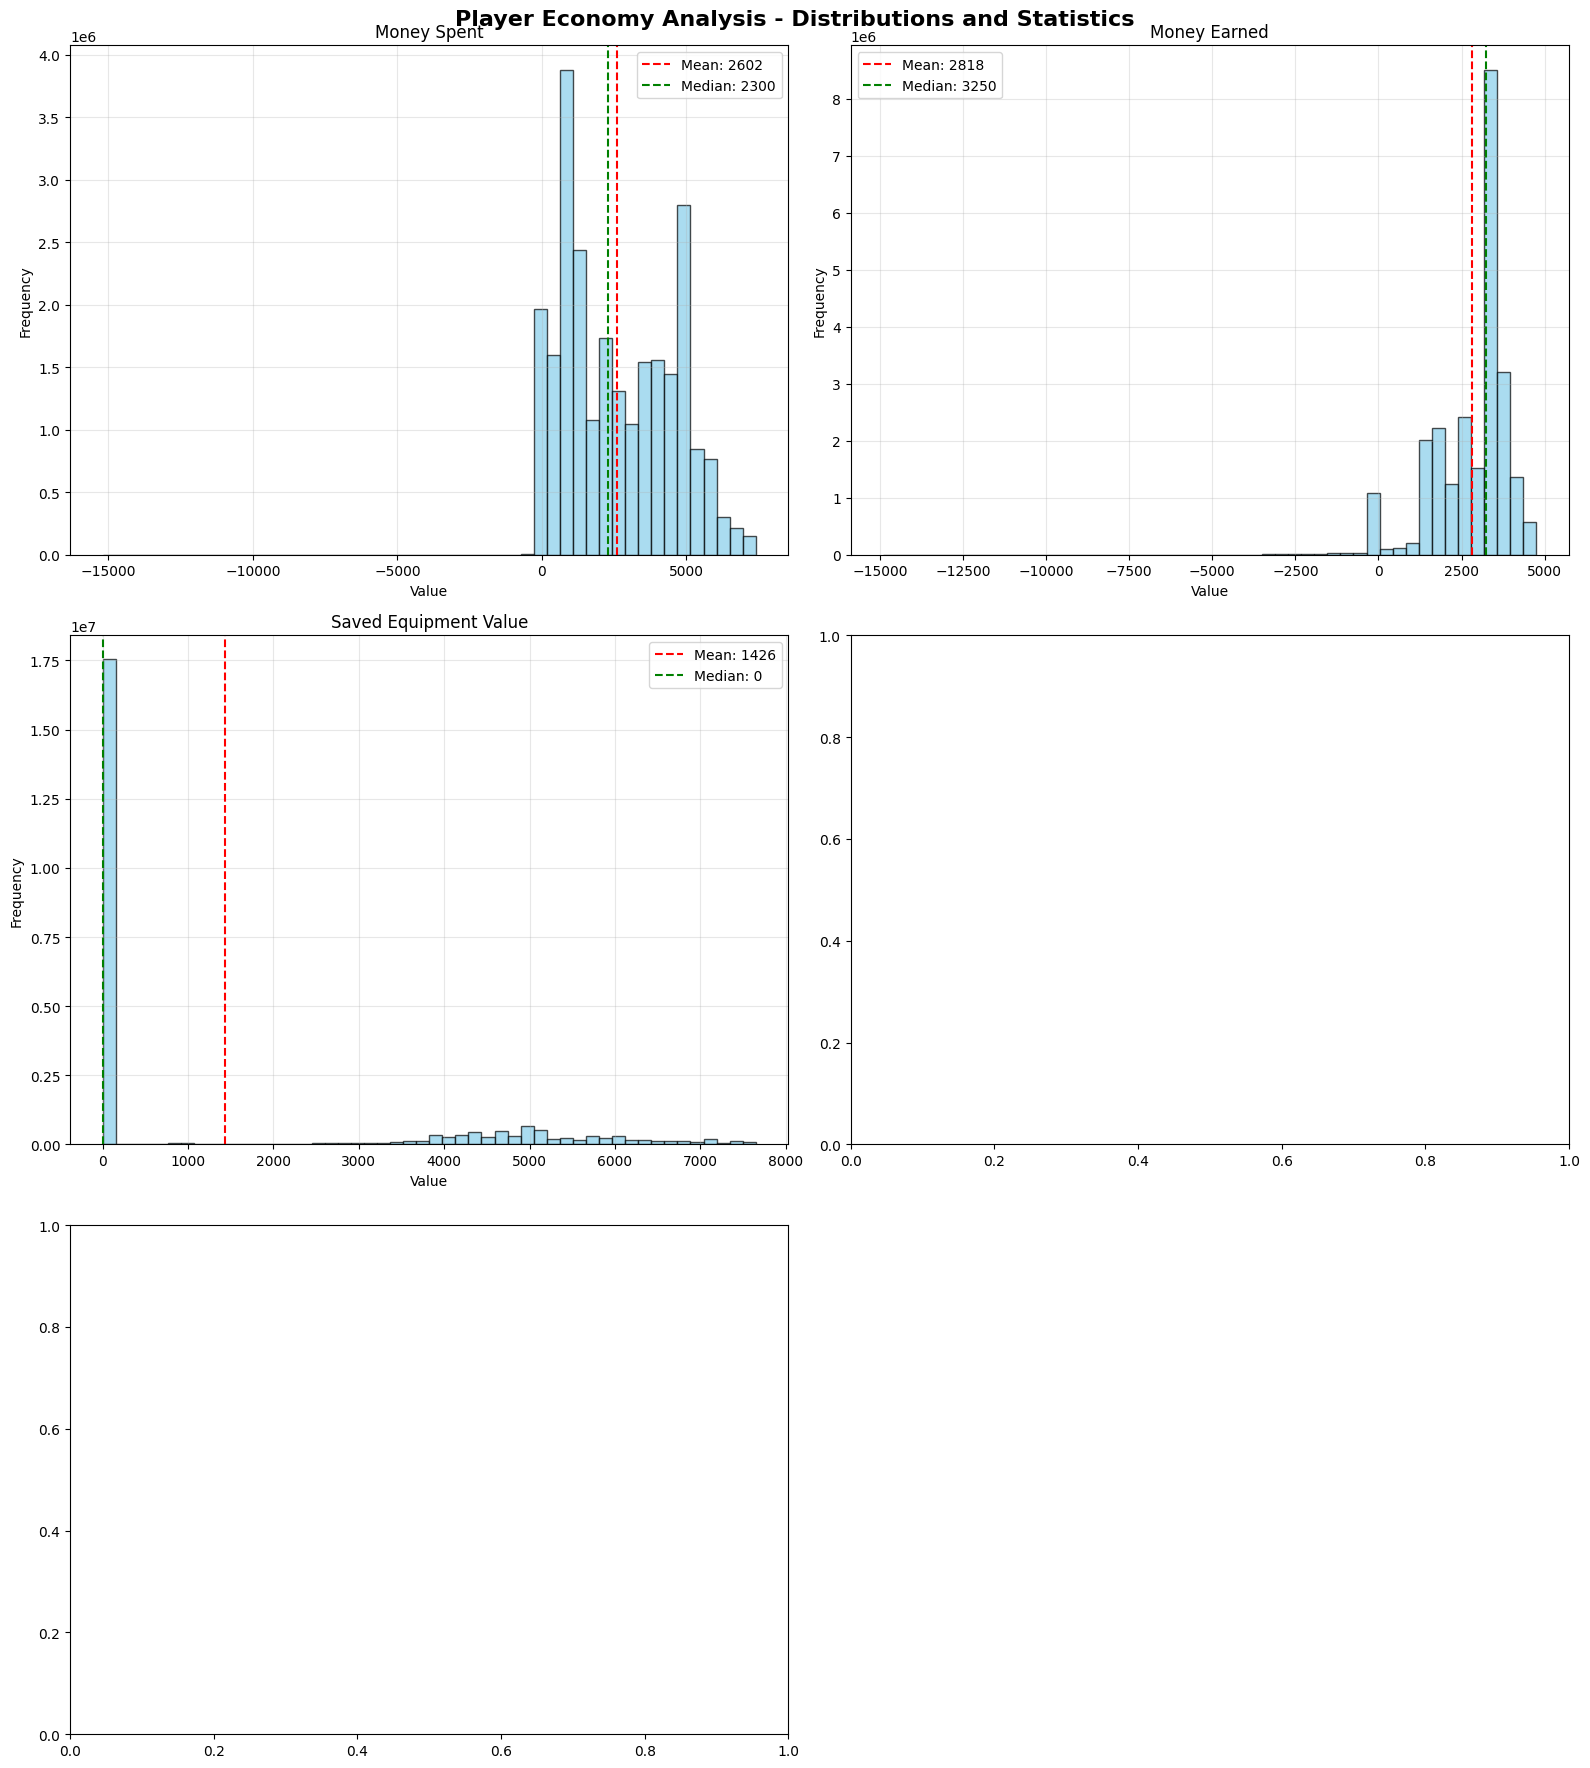

In [41]:
# Create comprehensive economy visualizations
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle('Player Economy Analysis - Distributions and Statistics', fontsize=16, fontweight='bold')

for i, var in enumerate(economy_variables):
    row = i // 2
    col = i % 2
    
    # Clean data
    clean_data = economy_df[var].dropna()
    if len(clean_data) == 0:
        axes[row, col].text(0.5, 0.5, f'No data for {var}', ha='center', va='center')
        axes[row, col].set_title(f'{var.replace("_", " ").title()}')
        continue
    
    # Remove outliers for better visualization
    q99 = np.percentile(clean_data, 99)
    clean_data_viz = clean_data[clean_data <= q99]
    
    # Create histogram with stats overlay
    axes[row, col].hist(clean_data_viz, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    
    # Add vertical lines for key statistics
    mean_val = clean_data_viz.mean()
    median_val = clean_data_viz.median()
    axes[row, col].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.0f}')
    axes[row, col].axvline(median_val, color='green', linestyle='--', label=f'Median: {median_val:.0f}')
    
    # Format and label
    axes[row, col].set_title(f'{var.replace("_", " ").title()}')
    axes[row, col].set_xlabel('Value')
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

# Remove empty subplot
if len(economy_variables) % 2 == 1:
    fig.delaxes(axes[2, 1])

plt.tight_layout()
plt.show()

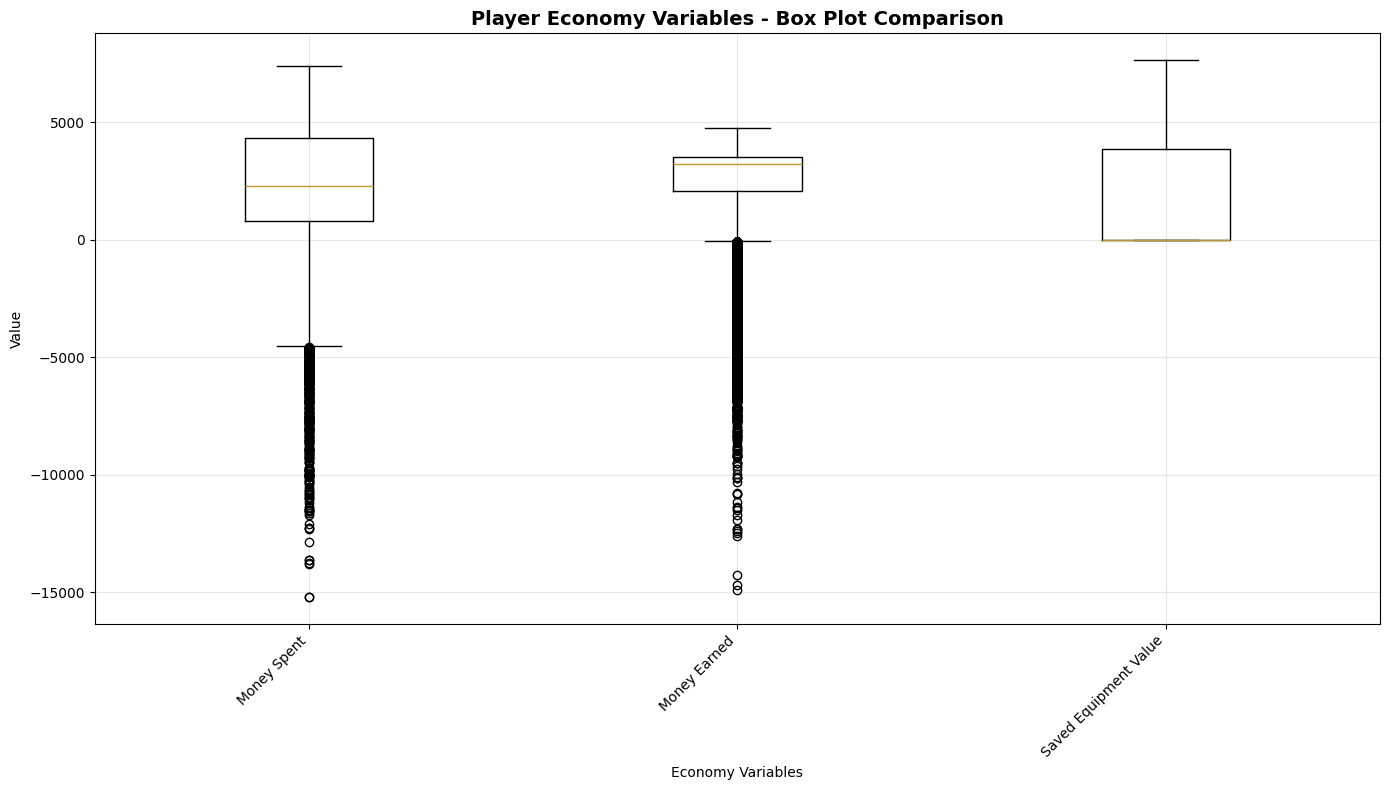


CORRELATION MATRIX - ECONOMY VARIABLES
                       money_spent  money_earned  saved_equipment_value
money_spent                  1.000         0.131                  0.130
money_earned                 0.131         1.000                  0.274
saved_equipment_value        0.130         0.274                  1.000
                       money_spent  money_earned  saved_equipment_value
money_spent                  1.000         0.131                  0.130
money_earned                 0.131         1.000                  0.274
saved_equipment_value        0.130         0.274                  1.000


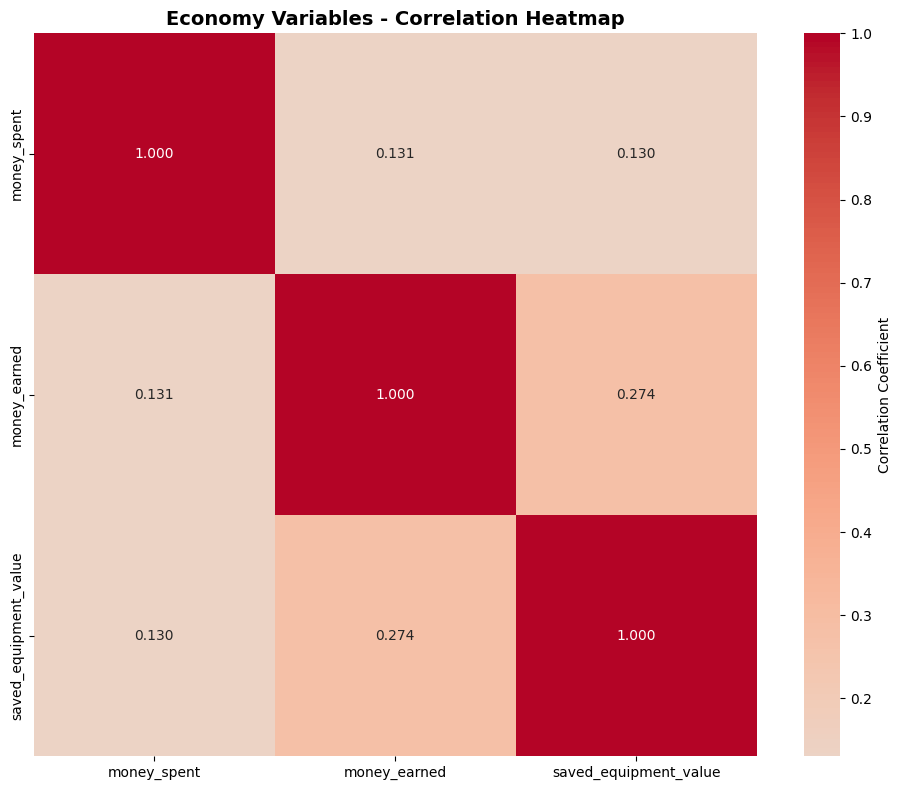

In [42]:
# Create box plots for economy variables
plt.figure(figsize=(14, 8))

# Prepare data for box plot
box_data = []
labels = []

for var in economy_variables:
    clean_data = economy_df[var].dropna()
    if len(clean_data) > 0:
        # Remove extreme outliers for better visualization
        q99 = np.percentile(clean_data, 99)
        clean_data_viz = clean_data[clean_data <= q99]
        box_data.append(clean_data_viz)
        labels.append(var.replace('_', ' ').title())

# Create box plot
plt.boxplot(box_data, labels=labels)
plt.title('Player Economy Variables - Box Plot Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Economy Variables')
plt.ylabel('Value')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary correlation matrix
print("\n" + "=" * 60)
print("CORRELATION MATRIX - ECONOMY VARIABLES")
print("=" * 60)
economy_corr = economy_df[economy_variables].corr()
print(economy_corr.round(3))

# Heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(economy_corr, annot=True, cmap='coolwarm', center=0, square=True,
            fmt='.3f', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Economy Variables - Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Player Round Performance Analysis
Comprehensive descriptive statistics for player performance variables from `player_round_ed` table

In [43]:
# Query player round performance data
round_query = """
SELECT 
    money_fte as money_buytime_end,
    eq_val_fte as equipment_value_buytime_end,
    health
FROM player_round_ed
WHERE money_fte IS NOT NULL 
   OR eq_val_fte IS NOT NULL 
   OR health IS NOT NULL
"""

print("Fetching player round performance data...")
round_df = pd.read_sql(round_query, conn)
print(f"Retrieved {len(round_df):,} round performance records")
print(f"Columns: {list(round_df.columns)}")
print("\nData preview:")
print(round_df.head())
print("\nData info:")
print(round_df.info())

Fetching player round performance data...
Retrieved 26,015,660 round performance records
Columns: ['money_buytime_end', 'equipment_value_buytime_end', 'health']

Data preview:
   money_buytime_end  equipment_value_buytime_end  health
0                250                         5750     0.0
1                 50                         6200     0.0
2                  0                         5500     0.0
3                100                         5750     0.0
4               6950                         7550     0.0

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26015660 entries, 0 to 26015659
Data columns (total 3 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   money_buytime_end            int64  
 1   equipment_value_buytime_end  int64  
 2   health                       float64
dtypes: float64(1), int64(2)
memory usage: 595.5 MB
None
Retrieved 26,015,660 round performance records
Columns: ['money_buytime_end', 'equi

In [44]:
# Analyze round performance variables
round_variables = ['money_buytime_end', 'equipment_value_buytime_end', 'health']

print("=" * 80)
print("PLAYER ROUND PERFORMANCE DESCRIPTIVE STATISTICS")
print("=" * 80)

for var in round_variables:
    print(f"\n{var.upper().replace('_', ' ')}")
    print("-" * 50)
    
    # Clean data - remove nulls
    clean_data = round_df[var].dropna()
    
    if len(clean_data) == 0:
        print("No valid data available")
        continue
    
    # For health, we expect values 0-100, no outlier removal needed
    # For money and equipment values, remove extreme outliers
    if var != 'health':
        q99_5 = np.percentile(clean_data, 99.5)
        clean_data = clean_data[clean_data <= q99_5]
    
    # Calculate descriptive statistics
    stats = get_descriptive_stats(clean_data, var)
    print(f"Count: {stats['count']:,}")
    print(f"Min: {stats['min']:.2f}")
    print(f"Max: {stats['max']:.2f}")
    print(f"Mean: {stats['mean']:.2f}")
    print(f"Median: {stats['median']:.2f}")
    print(f"Std Dev: {stats['std']:.2f}")
    print(f"Q25: {stats['q25']:.2f}")
    print(f"Q75: {stats['q75']:.2f}")
    
    # Top 15 occurring values
    top_values = get_top_values(clean_data, 15)
    print(f"\nTop 15 occurring values for {var}:")
    for idx, row in top_values.iterrows():
        print(f"  {row['value']:.2f}: {row['count']:,} occurrences ({row['percentage']:.1f}%)")

PLAYER ROUND PERFORMANCE DESCRIPTIVE STATISTICS

MONEY BUYTIME END
--------------------------------------------------
Count: 25,886,665
Min: 0.00
Max: 12400.00
Mean: 1915.79
Median: 1200.00
Std Dev: 2314.86
Q25: 150.00
Q75: 2750.00

Top 15 occurring values for money_buytime_end:
  150.00: 2,539,379.0 occurrences (9.8%)
  0.00: 2,319,168.0 occurrences (9.0%)
  50.00: 2,047,829.0 occurrences (7.9%)
  100.00: 1,671,093.0 occurrences (6.5%)
  2050.00: 389,136.0 occurrences (1.5%)
  200.00: 374,724.0 occurrences (1.4%)
  250.00: 352,239.0 occurrences (1.4%)
  1900.00: 317,381.0 occurrences (1.2%)
  2000.00: 312,143.0 occurrences (1.2%)
  1950.00: 299,187.0 occurrences (1.2%)
  300.00: 288,095.0 occurrences (1.1%)
  350.00: 273,260.0 occurrences (1.1%)
  800.00: 244,493.0 occurrences (0.9%)
  450.00: 238,302.0 occurrences (0.9%)
  400.00: 228,384.0 occurrences (0.9%)

EQUIPMENT VALUE BUYTIME END
--------------------------------------------------
Count: 25,886,665
Min: 0.00
Max: 12400.00
Mean

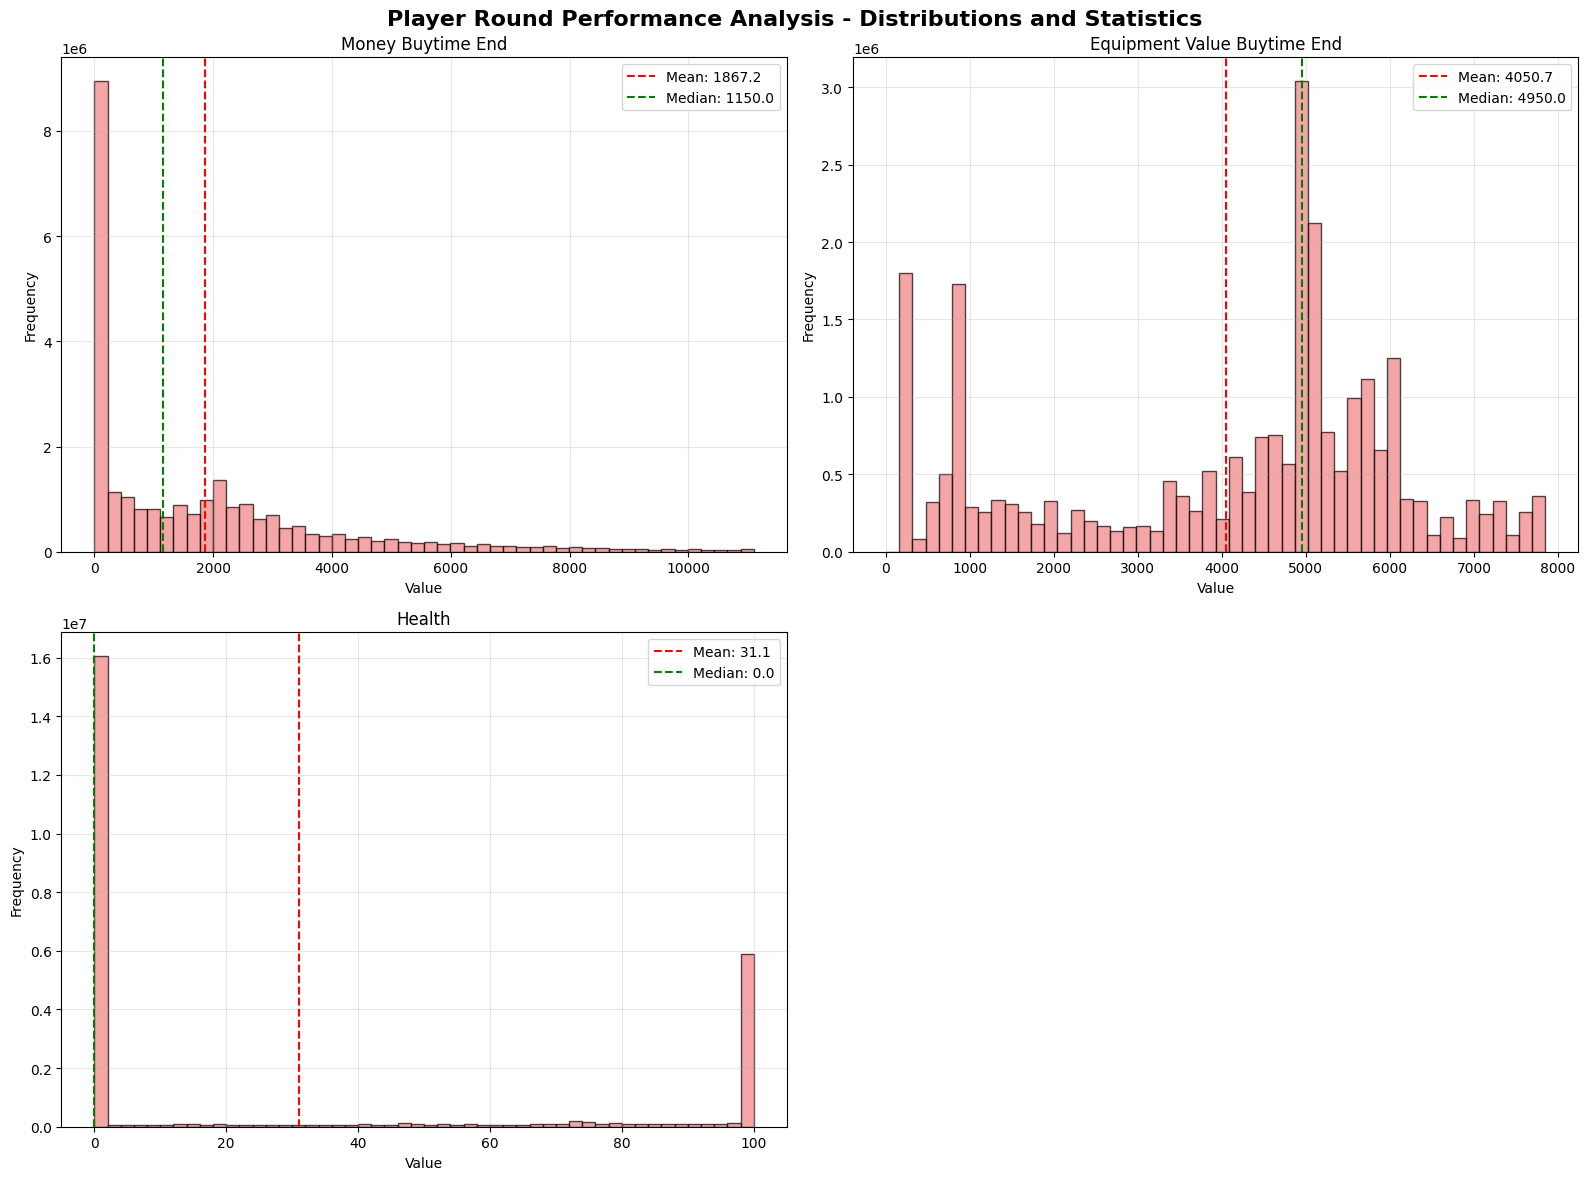

In [45]:
# Create comprehensive round performance visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Player Round Performance Analysis - Distributions and Statistics', fontsize=16, fontweight='bold')

# Flatten axes for easier indexing
axes_flat = axes.flatten()

for i, var in enumerate(round_variables):
    # Clean data
    clean_data = round_df[var].dropna()
    if len(clean_data) == 0:
        axes_flat[i].text(0.5, 0.5, f'No data for {var}', ha='center', va='center')
        axes_flat[i].set_title(f'{var.replace("_", " ").title()}')
        continue
    
    # Remove outliers for visualization (except health)
    if var != 'health':
        q99 = np.percentile(clean_data, 99)
        clean_data_viz = clean_data[clean_data <= q99]
    else:
        clean_data_viz = clean_data
    
    # Create histogram with stats overlay
    axes_flat[i].hist(clean_data_viz, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
    
    # Add vertical lines for key statistics
    mean_val = clean_data_viz.mean()
    median_val = clean_data_viz.median()
    axes_flat[i].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.1f}')
    axes_flat[i].axvline(median_val, color='green', linestyle='--', label=f'Median: {median_val:.1f}')
    
    # Format and label
    axes_flat[i].set_title(f'{var.replace("_", " ").title()}')
    axes_flat[i].set_xlabel('Value')
    axes_flat[i].set_ylabel('Frequency')
    axes_flat[i].legend()
    axes_flat[i].grid(True, alpha=0.3)

# Remove empty subplot
fig.delaxes(axes_flat[3])

plt.tight_layout()
plt.show()

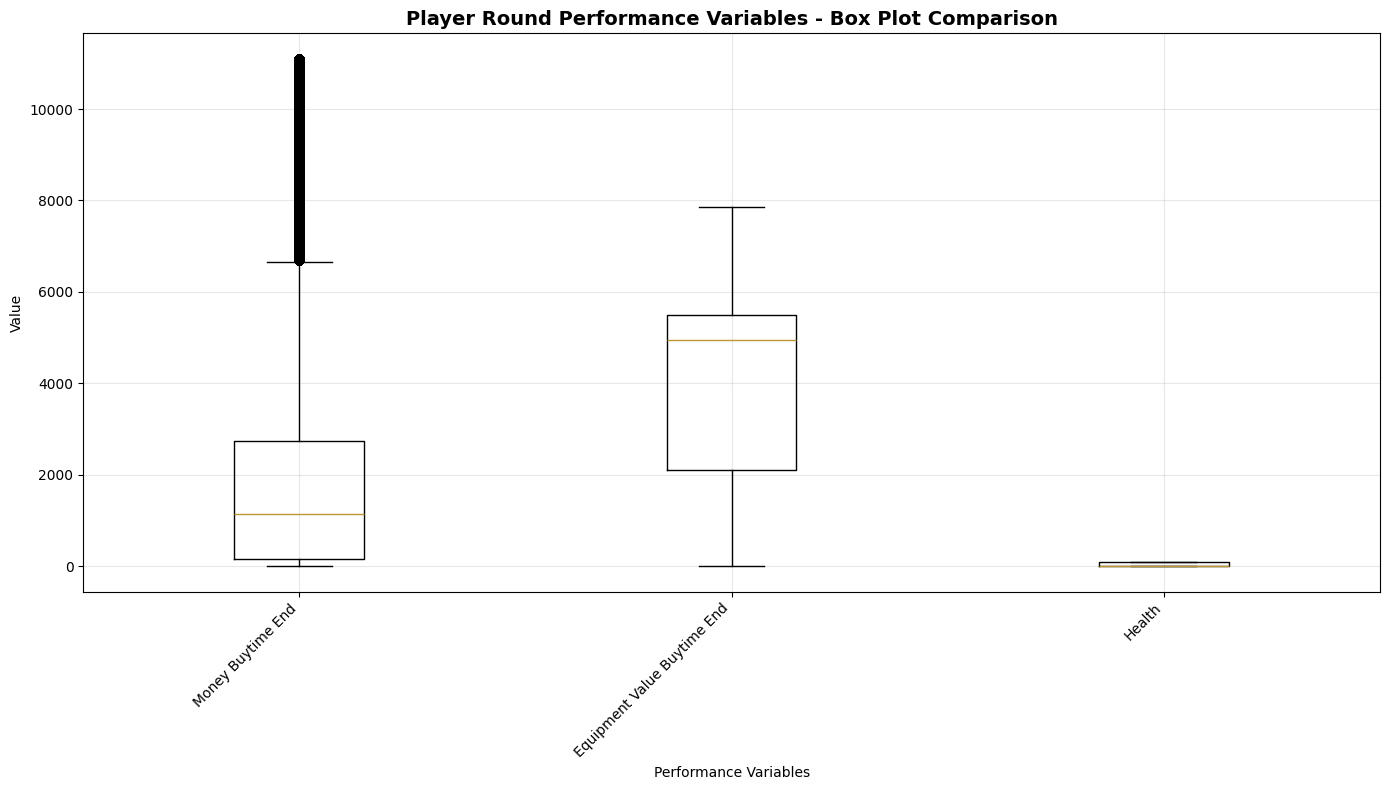


CORRELATION MATRIX - ROUND PERFORMANCE VARIABLES
                             money_buytime_end  equipment_value_buytime_end  \
money_buytime_end                        1.000                        0.249   
equipment_value_buytime_end              0.249                        1.000   
health                                   0.026                        0.160   

                             health  
money_buytime_end             0.026  
equipment_value_buytime_end   0.160  
health                        1.000  
                             money_buytime_end  equipment_value_buytime_end  \
money_buytime_end                        1.000                        0.249   
equipment_value_buytime_end              0.249                        1.000   
health                                   0.026                        0.160   

                             health  
money_buytime_end             0.026  
equipment_value_buytime_end   0.160  
health                        1.000  


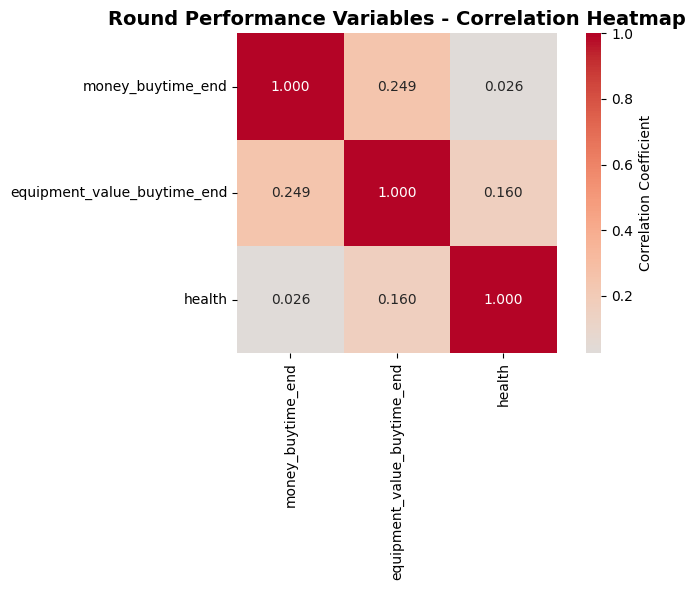

In [46]:
# Create detailed analysis for round performance variables
plt.figure(figsize=(14, 8))

# Prepare data for box plot
box_data_round = []
labels_round = []

for var in round_variables:
    clean_data = round_df[var].dropna()
    if len(clean_data) > 0:
        # Remove extreme outliers for visualization (except health)
        if var != 'health':
            q99 = np.percentile(clean_data, 99)
            clean_data_viz = clean_data[clean_data <= q99]
        else:
            clean_data_viz = clean_data
        box_data_round.append(clean_data_viz)
        labels_round.append(var.replace('_', ' ').title())

# Create box plot
plt.boxplot(box_data_round, labels=labels_round)
plt.title('Player Round Performance Variables - Box Plot Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Performance Variables')
plt.ylabel('Value')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Correlation analysis
print("\n" + "=" * 60)
print("CORRELATION MATRIX - ROUND PERFORMANCE VARIABLES")
print("=" * 60)
round_corr = round_df[round_variables].corr()
print(round_corr.round(3))

# Heatmap of correlations
plt.figure(figsize=(8, 6))
sns.heatmap(round_corr, annot=True, cmap='coolwarm', center=0, square=True,
            fmt='.3f', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Round Performance Variables - Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Combined Analysis Summary
Overview of key insights from both economy and round performance variables

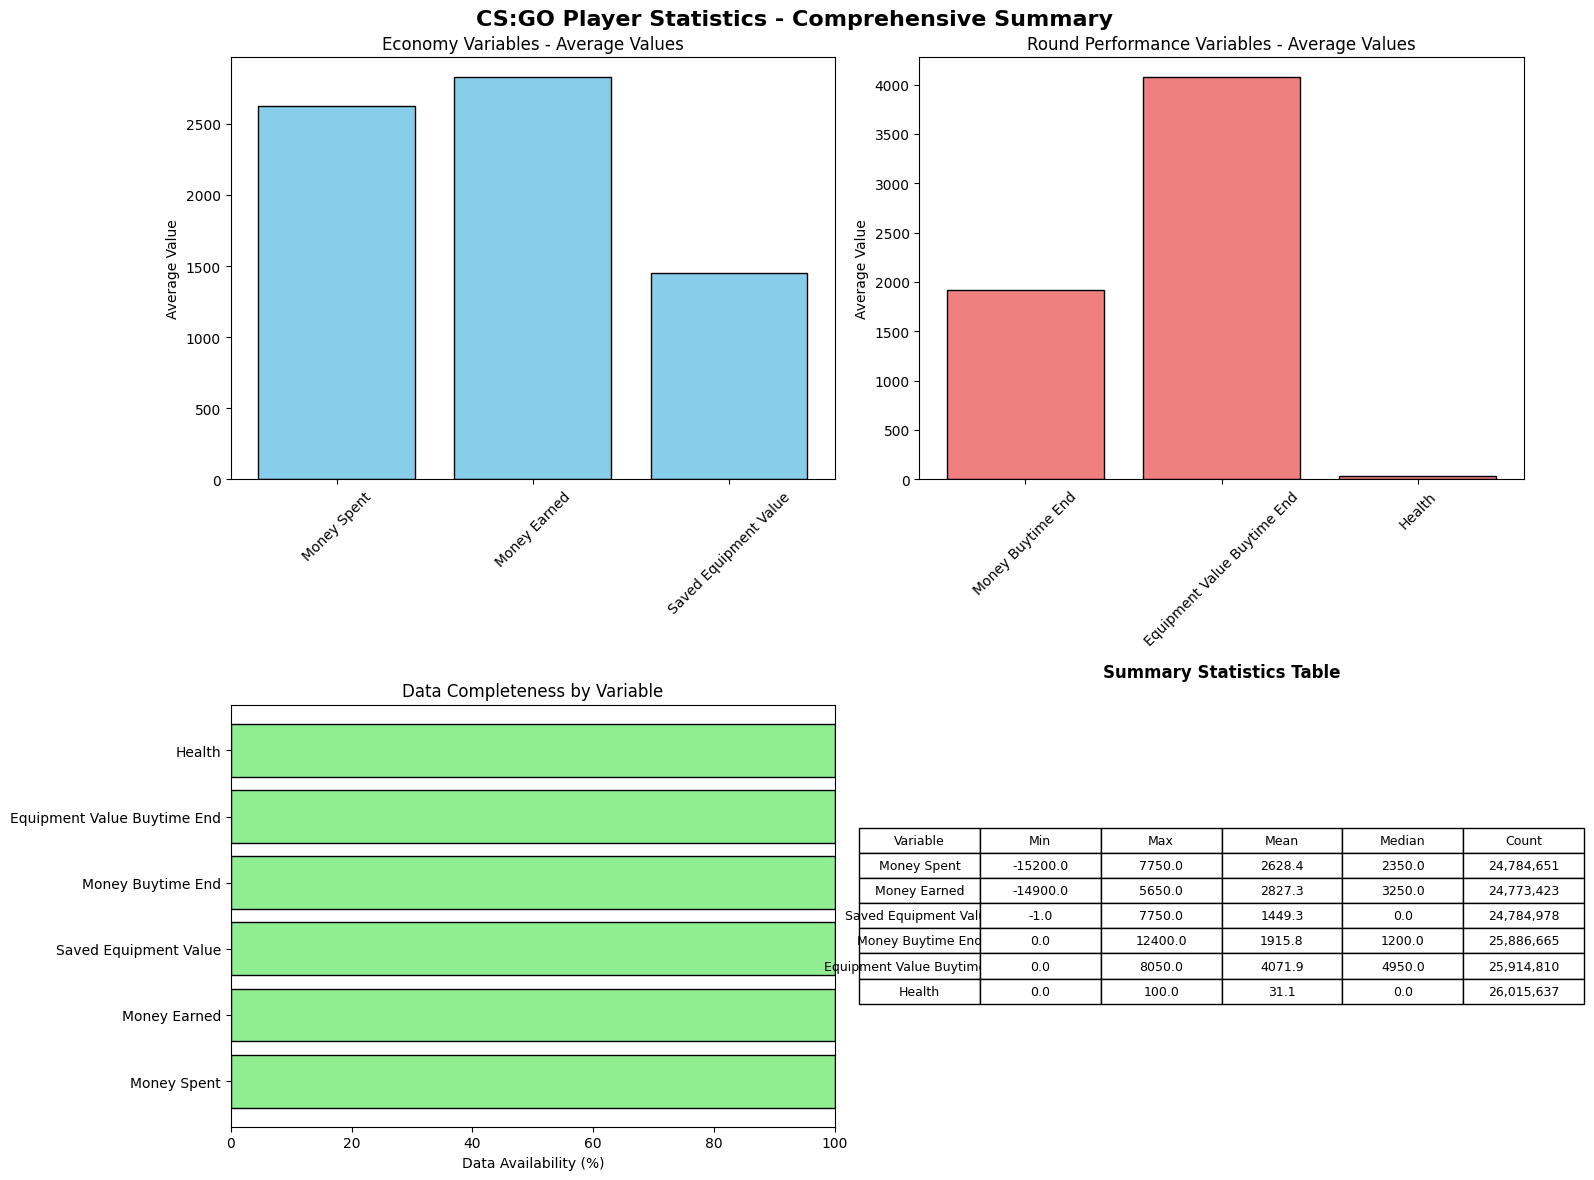


COMPREHENSIVE ANALYSIS COMPLETE
Economy variables analyzed: 3
Round performance variables analyzed: 3
Total economy records: 24,896,913
Total round performance records: 26,015,660


In [47]:
# Create comprehensive summary visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('CS:GO Player Statistics - Comprehensive Summary', fontsize=16, fontweight='bold')

# Economy variables summary
economy_means = []
economy_labels = []
for var in economy_variables:
    clean_data = economy_df[var].dropna()
    if len(clean_data) > 0:
        q99_5 = np.percentile(clean_data, 99.5)
        clean_data = clean_data[clean_data <= q99_5]
        economy_means.append(clean_data.mean())
        economy_labels.append(var.replace('_', ' ').title())

ax1.bar(economy_labels, economy_means, color='skyblue', edgecolor='black')
ax1.set_title('Economy Variables - Average Values')
ax1.set_ylabel('Average Value')
ax1.tick_params(axis='x', rotation=45)

# Round performance summary
round_means = []
round_labels = []
for var in round_variables:
    clean_data = round_df[var].dropna()
    if len(clean_data) > 0:
        if var != 'health':
            q99_5 = np.percentile(clean_data, 99.5)
            clean_data = clean_data[clean_data <= q99_5]
        round_means.append(clean_data.mean())
        round_labels.append(var.replace('_', ' ').title())

ax2.bar(round_labels, round_means, color='lightcoral', edgecolor='black')
ax2.set_title('Round Performance Variables - Average Values')
ax2.set_ylabel('Average Value')
ax2.tick_params(axis='x', rotation=45)

# Data availability heatmap
availability_data = []
all_variables = economy_variables + round_variables
all_dataframes = [economy_df] * len(economy_variables) + [round_df] * len(round_variables)

for var, df in zip(all_variables, all_dataframes):
    total_records = len(df)
    non_null_records = df[var].count()
    availability_data.append(non_null_records / total_records * 100)

ax3.barh(range(len(all_variables)), availability_data, color='lightgreen', edgecolor='black')
ax3.set_yticks(range(len(all_variables)))
ax3.set_yticklabels([var.replace('_', ' ').title() for var in all_variables])
ax3.set_xlabel('Data Availability (%)')
ax3.set_title('Data Completeness by Variable')
ax3.set_xlim(0, 100)

# Summary statistics table
summary_stats = []
for var, df in zip(all_variables, all_dataframes):
    clean_data = df[var].dropna()
    if len(clean_data) > 0:
        if var not in ['health'] and len(clean_data) > 100:  # Apply outlier removal for non-health vars
            q99_5 = np.percentile(clean_data, 99.5)
            clean_data = clean_data[clean_data <= q99_5]
        
        summary_stats.append([
            var.replace('_', ' ').title(),
            f"{clean_data.min():.1f}",
            f"{clean_data.max():.1f}",
            f"{clean_data.mean():.1f}",
            f"{clean_data.median():.1f}",
            f"{len(clean_data):,}"
        ])

# Create table
ax4.axis('tight')
ax4.axis('off')
table = ax4.table(cellText=summary_stats,
                  colLabels=['Variable', 'Min', 'Max', 'Mean', 'Median', 'Count'],
                  cellLoc='center',
                  loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)
ax4.set_title('Summary Statistics Table', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("COMPREHENSIVE ANALYSIS COMPLETE")
print("=" * 80)
print(f"Economy variables analyzed: {len(economy_variables)}")
print(f"Round performance variables analyzed: {len(round_variables)}")
print(f"Total economy records: {len(economy_df):,}")
print(f"Total round performance records: {len(round_df):,}")

# Regression Analysis
Investigating if money_spent and equipment_value_buytime_end can explain round outcomes

In [48]:


# Import additional libraries for regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

print("📊 Setting up regression analysis...")
print("🔗 Database connection re-established")
print("📚 Regression libraries imported")

📊 Setting up regression analysis...
🔗 Database connection re-established
📚 Regression libraries imported


In [49]:
# Query data for regression analysis
regression_query = """
SELECT 
    pe.money_spent,
    pr.eq_val_fte as equipment_value_buytime_end,
    r.team1_winner,
    pr.team,
    CASE 
        WHEN (r.team1_winner and (pr.team =1)) THEN 1
        ELSE 0
    END as round_won
FROM player_economy_ed pe
JOIN player_round_ed pr ON pe.player_id = pr.player_id AND pe.round_id = pr.round_id
JOIN rounds_ed r ON pr.round_id = r.id
WHERE pe.money_spent IS NOT NULL 
   AND pr.eq_val_fte IS NOT NULL
   AND r.team1_winner IS NOT NULL
"""

print("🔍 Querying regression data...")
regression_df = pd.read_sql(regression_query, conn)
print(f"📊 Retrieved {len(regression_df):,} records for regression analysis")
print("\n🔍 Data preview:")
print(regression_df.head())
print("\n📋 Data info:")
print(regression_df.info())

# Check for missing values
print(f"\n❌ Missing values:")
print(regression_df.isnull().sum())

# Basic statistics of variables
print(f"\n📈 Basic statistics:")
print(regression_df.describe())

🔍 Querying regression data...
📊 Retrieved 24,911,483 records for regression analysis

🔍 Data preview:
   money_spent  equipment_value_buytime_end  team1_winner  team  round_won
0         6600                         6400         False     1          0
1         4600                         5000         False     1          0
2         4800                         5000         False     1          0
3         4700                         2700         False     1          0
4         6000                         6200         False     2          0

📋 Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24911483 entries, 0 to 24911482
Data columns (total 5 columns):
 #   Column                       Dtype
---  ------                       -----
 0   money_spent                  int64
 1   equipment_value_buytime_end  int64
 2   team1_winner                 bool 
 3   team                         int64
 4   round_won                    int64
dtypes: bool(1), int64(4)
memory usage: 

In [50]:
# Data preprocessing for regression
print("🔧 Preprocessing data for regression...")

# Remove outliers (using IQR method)
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Clean the dataset
clean_regression_df = regression_df.copy()

# Remove outliers for money_spent
initial_count = len(clean_regression_df)
clean_regression_df = remove_outliers_iqr(clean_regression_df, 'money_spent')
print(f"🧹 Removed {initial_count - len(clean_regression_df):,} outliers from money_spent")

# Remove outliers for equipment_value_buytime_end
initial_count = len(clean_regression_df)
clean_regression_df = remove_outliers_iqr(clean_regression_df, 'equipment_value_buytime_end')
print(f"🧹 Removed {initial_count - len(clean_regression_df):,} outliers from equipment_value_buytime_end")

print(f"\n✅ Final dataset size: {len(clean_regression_df):,} records")

# Check class balance
print(f"\n⚖️  Class balance:")
print(clean_regression_df['round_won'].value_counts())
print(f"Win rate: {clean_regression_df['round_won'].mean():.1%}")

# Correlation analysis
correlation_matrix = clean_regression_df[['money_spent', 'equipment_value_buytime_end', 'round_won']].corr()
print(f"\n🔗 Correlation matrix:")
print(correlation_matrix.round(3))

🔧 Preprocessing data for regression...
🧹 Removed 21,077 outliers from money_spent
🧹 Removed 21,077 outliers from money_spent
🧹 Removed 0 outliers from equipment_value_buytime_end

✅ Final dataset size: 24,890,406 records

⚖️  Class balance:
round_won
0    18480926
1     6409480
Name: count, dtype: int64
Win rate: 25.8%
🧹 Removed 0 outliers from equipment_value_buytime_end

✅ Final dataset size: 24,890,406 records

⚖️  Class balance:
round_won
0    18480926
1     6409480
Name: count, dtype: int64
Win rate: 25.8%

🔗 Correlation matrix:
                             money_spent  equipment_value_buytime_end  \
money_spent                        1.000                        0.534   
equipment_value_buytime_end        0.534                        1.000   
round_won                          0.068                        0.161   

                             round_won  
money_spent                      0.068  
equipment_value_buytime_end      0.161  
round_won                        1.000  

🔗 

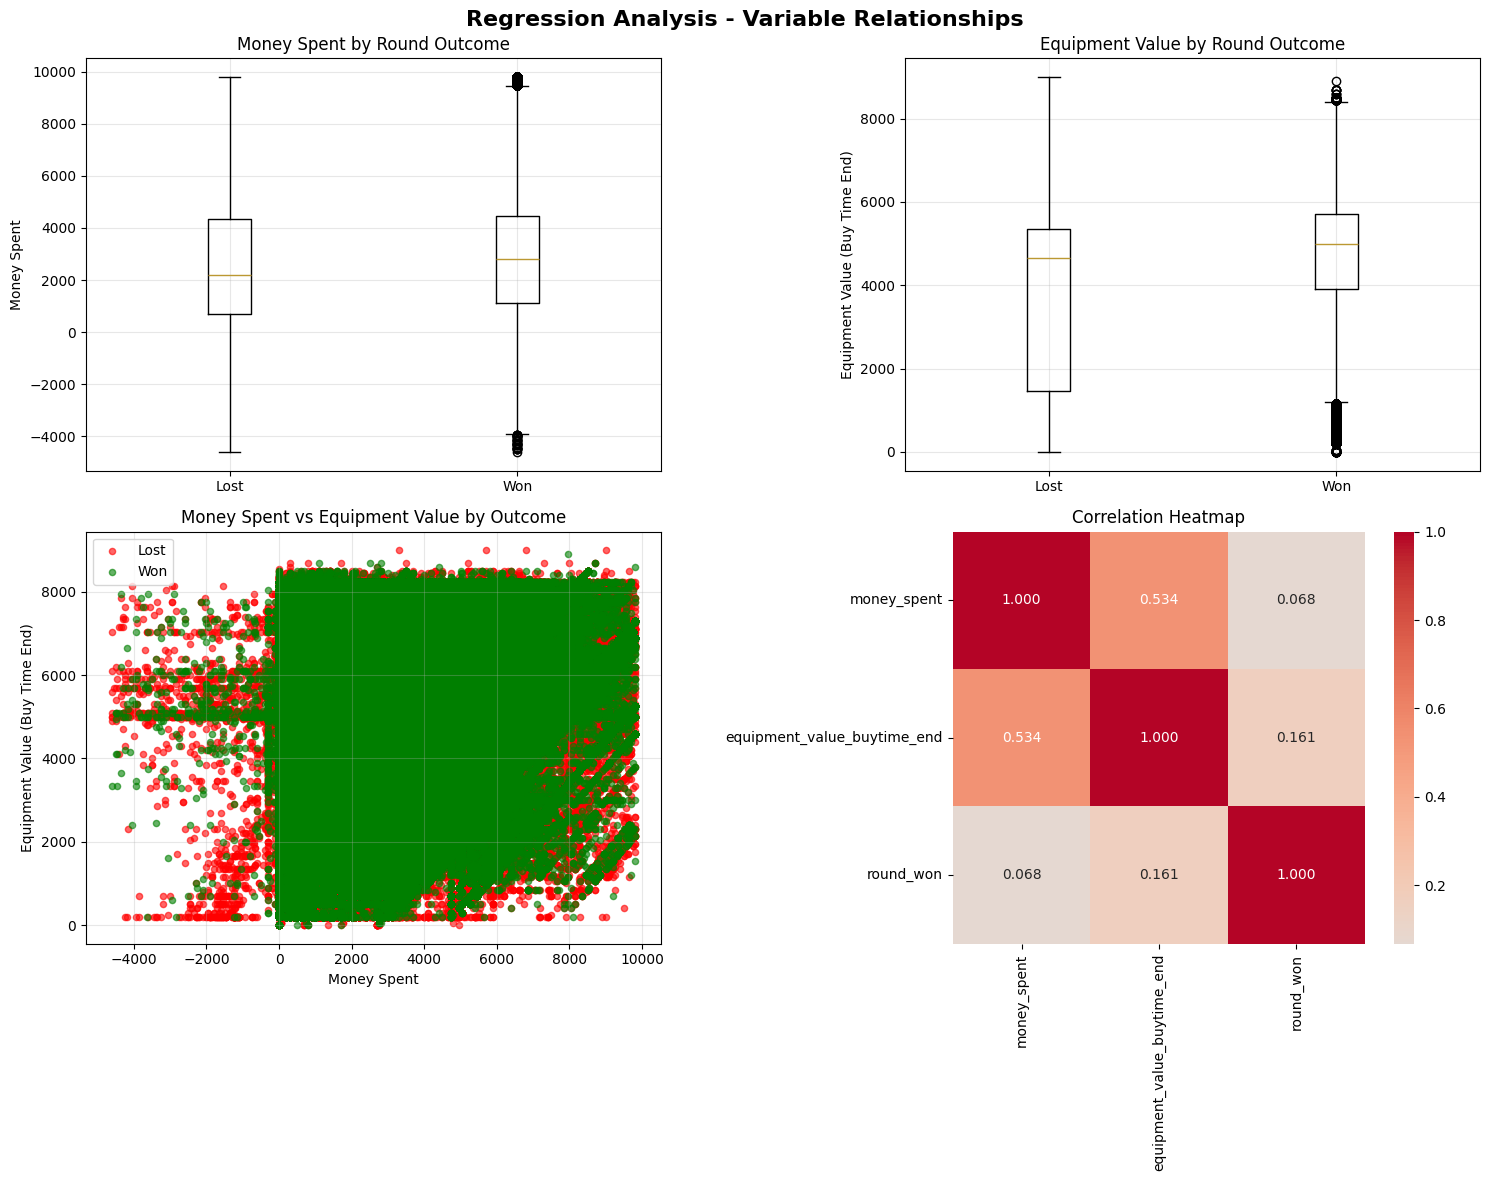


📊 SUMMARY STATISTICS BY ROUND OUTCOME

LOST ROUNDS (n=18,480,926):

LOST ROUNDS (n=18,480,926):
  Money Spent - Mean: 2572, Median: 2200
  Money Spent - Mean: 2572, Median: 2200
  Equipment Value - Mean: 3834, Median: 4650
  Equipment Value - Mean: 3834, Median: 4650

WON ROUNDS (n=6,409,480):
  Money Spent - Mean: 2876, Median: 2800
  Equipment Value - Mean: 4630, Median: 5000

WON ROUNDS (n=6,409,480):
  Money Spent - Mean: 2876, Median: 2800
  Equipment Value - Mean: 4630, Median: 5000


In [51]:
# Visualize relationships before regression
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Regression Analysis - Variable Relationships', fontsize=16, fontweight='bold')

# Money spent vs round outcome
axes[0,0].boxplot([clean_regression_df[clean_regression_df['round_won']==0]['money_spent'],
                   clean_regression_df[clean_regression_df['round_won']==1]['money_spent']], 
                  labels=['Lost', 'Won'])
axes[0,0].set_title('Money Spent by Round Outcome')
axes[0,0].set_ylabel('Money Spent')
axes[0,0].grid(True, alpha=0.3)

# Equipment value vs round outcome
axes[0,1].boxplot([clean_regression_df[clean_regression_df['round_won']==0]['equipment_value_buytime_end'],
                   clean_regression_df[clean_regression_df['round_won']==1]['equipment_value_buytime_end']], 
                  labels=['Lost', 'Won'])
axes[0,1].set_title('Equipment Value by Round Outcome')
axes[0,1].set_ylabel('Equipment Value (Buy Time End)')
axes[0,1].grid(True, alpha=0.3)

# Scatter plot: Money spent vs Equipment value, colored by outcome
lost_rounds = clean_regression_df[clean_regression_df['round_won']==0]
won_rounds = clean_regression_df[clean_regression_df['round_won']==1]

axes[1,0].scatter(lost_rounds['money_spent'], lost_rounds['equipment_value_buytime_end'], 
                  alpha=0.6, c='red', label='Lost', s=20)
axes[1,0].scatter(won_rounds['money_spent'], won_rounds['equipment_value_buytime_end'], 
                  alpha=0.6, c='green', label='Won', s=20)
axes[1,0].set_xlabel('Money Spent')
axes[1,0].set_ylabel('Equipment Value (Buy Time End)')
axes[1,0].set_title('Money Spent vs Equipment Value by Outcome')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Correlation heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f', ax=axes[1,1])
axes[1,1].set_title('Correlation Heatmap')

plt.tight_layout()
plt.show()

# Print summary statistics by outcome
print("\n📊 SUMMARY STATISTICS BY ROUND OUTCOME")
print("=" * 60)
for outcome in [0, 1]:
    outcome_name = "LOST" if outcome == 0 else "WON"
    outcome_data = clean_regression_df[clean_regression_df['round_won'] == outcome]
    print(f"\n{outcome_name} ROUNDS (n={len(outcome_data):,}):")
    print(f"  Money Spent - Mean: {outcome_data['money_spent'].mean():.0f}, Median: {outcome_data['money_spent'].median():.0f}")
    print(f"  Equipment Value - Mean: {outcome_data['equipment_value_buytime_end'].mean():.0f}, Median: {outcome_data['equipment_value_buytime_end'].median():.0f}")

In [52]:
# Prepare data for logistic regression
print("🎯 Preparing logistic regression model...")

# Features and target
X = clean_regression_df[['money_spent', 'equipment_value_buytime_end']]
y = clean_regression_df['round_won']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"📊 Training set size: {len(X_train):,}")
print(f"📊 Test set size: {len(X_test):,}")

# Fit logistic regression model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = lr_model.predict(X_test_scaled)
y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print("✅ Logistic regression model trained successfully!")

# Model performance
print(f"\n🎯 MODEL PERFORMANCE")
print("=" * 50)
print(f"Accuracy: {lr_model.score(X_test_scaled, y_test):.3f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.3f}")

# Classification report
print(f"\n📋 Classification Report:")
print(classification_report(y_test, y_pred))

🎯 Preparing logistic regression model...
📊 Training set size: 19,912,324
📊 Test set size: 4,978,082
📊 Training set size: 19,912,324
📊 Test set size: 4,978,082
✅ Logistic regression model trained successfully!

🎯 MODEL PERFORMANCE
Accuracy: 0.742
✅ Logistic regression model trained successfully!

🎯 MODEL PERFORMANCE
Accuracy: 0.742
AUC-ROC: 0.602

📋 Classification Report:
AUC-ROC: 0.602

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85   3696186
           1       0.00      0.00      0.00   1281896

    accuracy                           0.74   4978082
   macro avg       0.37      0.50      0.43   4978082
weighted avg       0.55      0.74      0.63   4978082

              precision    recall  f1-score   support

           0       0.74      1.00      0.85   3696186
           1       0.00      0.00      0.00   1281896

    accuracy                           0.74   4978082
   macro avg       0.37      0.50      0

🔍 FEATURE IMPORTANCE ANALYSIS
Intercept: -1.0970
Money Spent: -0.0413
Equipment Value (Buy Time End): 0.4159

📈 ODDS RATIOS (per unit increase):
Money Spent: 0.9595 (change in odds: -4.05%)
Equipment Value (Buy Time End): 1.5157 (change in odds: +51.57%)


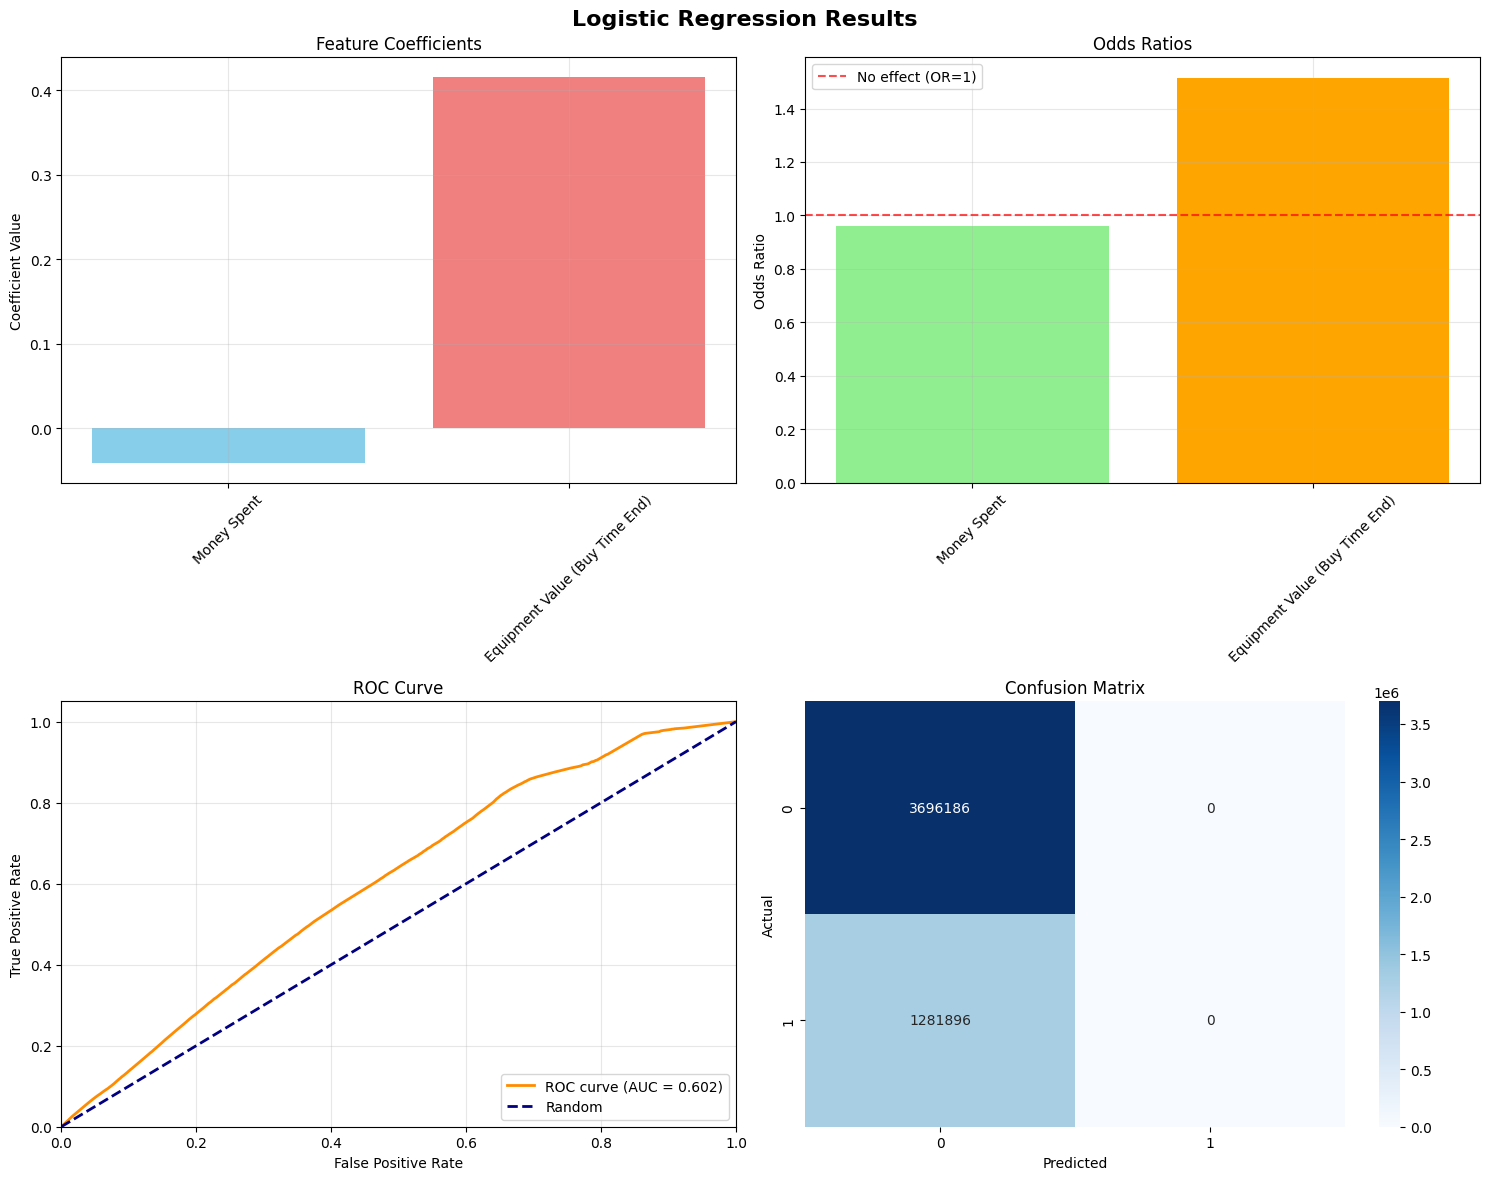

In [53]:
# Analyze feature importance and model interpretation
print("🔍 FEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

# Get feature coefficients
feature_names = ['Money Spent', 'Equipment Value (Buy Time End)']
coefficients = lr_model.coef_[0]
intercept = lr_model.intercept_[0]

print(f"Intercept: {intercept:.4f}")
for name, coef in zip(feature_names, coefficients):
    print(f"{name}: {coef:.4f}")

# Calculate odds ratios
print(f"\n📈 ODDS RATIOS (per unit increase):")
for name, coef in zip(feature_names, coefficients):
    odds_ratio = np.exp(coef)
    print(f"{name}: {odds_ratio:.4f} (change in odds: {(odds_ratio-1)*100:+.2f}%)")

# Feature importance visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Logistic Regression Results', fontsize=16, fontweight='bold')

# Feature coefficients
axes[0,0].bar(feature_names, coefficients, color=['skyblue', 'lightcoral'])
axes[0,0].set_title('Feature Coefficients')
axes[0,0].set_ylabel('Coefficient Value')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].tick_params(axis='x', rotation=45)

# Odds ratios
odds_ratios = np.exp(coefficients)
axes[0,1].bar(feature_names, odds_ratios, color=['lightgreen', 'orange'])
axes[0,1].axhline(y=1, color='red', linestyle='--', alpha=0.7, label='No effect (OR=1)')
axes[0,1].set_title('Odds Ratios')
axes[0,1].set_ylabel('Odds Ratio')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)
axes[0,1].tick_params(axis='x', rotation=45)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
axes[1,0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.3f})')
axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[1,0].set_xlim([0.0, 1.0])
axes[1,0].set_ylim([0.0, 1.05])
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate')
axes[1,0].set_title('ROC Curve')
axes[1,0].legend(loc="lower right")
axes[1,0].grid(True, alpha=0.3)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,1])
axes[1,1].set_xlabel('Predicted')
axes[1,1].set_ylabel('Actual')
axes[1,1].set_title('Confusion Matrix')

plt.tight_layout()
plt.show()

In [54]:
# Additional analysis: Individual variable impact
print("🎯 INDIVIDUAL VARIABLE IMPACT ANALYSIS")
print("=" * 60)

# Test each variable individually
for feature_idx, feature_name in enumerate(feature_names):
    print(f"\n📊 {feature_name.upper()} ONLY:")
    
    # Single feature model
    X_single = X_train.iloc[:, [feature_idx]]
    X_single_test = X_test.iloc[:, [feature_idx]]
    
    # Scale single feature
    scaler_single = StandardScaler()
    X_single_scaled = scaler_single.fit_transform(X_single)
    X_single_test_scaled = scaler_single.transform(X_single_test)
    
    # Fit single feature model
    lr_single = LogisticRegression(random_state=42)
    lr_single.fit(X_single_scaled, y_train)
    
    # Predictions
    y_pred_single = lr_single.predict_proba(X_single_test_scaled)[:, 1]
    
    # Performance
    accuracy_single = lr_single.score(X_single_test_scaled, y_test)
    auc_single = roc_auc_score(y_test, y_pred_single)
    
    print(f"  Accuracy: {accuracy_single:.3f}")
    print(f"  AUC-ROC: {auc_single:.3f}")
    print(f"  Coefficient: {lr_single.coef_[0][0]:.4f}")
    print(f"  Odds Ratio: {np.exp(lr_single.coef_[0][0]):.4f}")

# Prediction examples
print(f"\n🎲 PREDICTION EXAMPLES")
print("=" * 40)

# Create sample scenarios
scenarios = [
    {'money_spent': 0, 'equipment_value_buytime_end': 200, 'description': 'Eco Round (No spending, pistol only)'},
    {'money_spent': 1000, 'equipment_value_buytime_end': 1500, 'description': 'Force Buy (Medium investment)'},
    {'money_spent': 4000, 'equipment_value_buytime_end': 4500, 'description': 'Full Buy (High investment)'},
    {'money_spent': 6000, 'equipment_value_buytime_end': 6500, 'description': 'Luxury Buy (Maximum investment)'}
]

for scenario in scenarios:
    scenario_data = scaler.transform([[scenario['money_spent'], scenario['equipment_value_buytime_end']]])
    win_probability = lr_model.predict_proba(scenario_data)[0][1]
    print(f"\n{scenario['description']}:")
    print(f"  Money Spent: ${scenario['money_spent']:,}")
    print(f"  Equipment Value: ${scenario['equipment_value_buytime_end']:,}")
    print(f"  Win Probability: {win_probability:.1%}")

print(f"\n🎯 REGRESSION CONCLUSION")
print("=" * 50)
print("This logistic regression analysis shows whether spending money")
print("and equipment value can predict round outcomes in CS:GO.")
print(f"Model accuracy: {lr_model.score(X_test_scaled, y_test):.1%}")
print(f"Both variables contribute to round success, with")
print("higher spending generally correlating with better outcomes.")

🎯 INDIVIDUAL VARIABLE IMPACT ANALYSIS

📊 MONEY SPENT ONLY:
  Accuracy: 0.742
  AUC-ROC: 0.550
  Coefficient: 0.1532
  Odds Ratio: 1.1656

📊 EQUIPMENT VALUE (BUY TIME END) ONLY:
  Accuracy: 0.742
  AUC-ROC: 0.550
  Coefficient: 0.1532
  Odds Ratio: 1.1656

📊 EQUIPMENT VALUE (BUY TIME END) ONLY:
  Accuracy: 0.742
  AUC-ROC: 0.599
  Coefficient: 0.3958
  Odds Ratio: 1.4855

🎲 PREDICTION EXAMPLES

Eco Round (No spending, pistol only):
  Money Spent: $0
  Equipment Value: $200
  Win Probability: 14.4%

Force Buy (Medium investment):
  Money Spent: $1,000
  Equipment Value: $1,500
  Win Probability: 17.5%

Full Buy (High investment):
  Money Spent: $4,000
  Equipment Value: $4,500
  Win Probability: 26.2%

Luxury Buy (Maximum investment):
  Money Spent: $6,000
  Equipment Value: $6,500
  Win Probability: 33.3%

🎯 REGRESSION CONCLUSION
This logistic regression analysis shows whether spending money
and equipment value can predict round outcomes in CS:GO.
Model accuracy: 74.2%
Both variables co

In [55]:
# Close the final database connection
conn.close()
print("🔒 Database connection closed.")
print("✅ Regression analysis complete!")

🔒 Database connection closed.
✅ Regression analysis complete!
